In [1]:
#author = 0712238@NCTU, Maxwill Lin, YT Lin
#last update = 2019.11.07
#usage = HW1 of Deep Learning 2019 fall @ NCTU 
#regression part 
#preprocess with normaliztion and one-hot vectorization
#NN architectur = NN([17, 10, 5, 1],activations=['sigmoid', 'sigmoid', 'relu'], usage = 'regression')
#train and test with split data set
#learning curve + train/test RMS
#save files

#2019.11.06-07 some bug fixed, improvement on weight init, experiments
#2019.11.07 fix relu last activation cause 0 gradient bug, experiment on lr 
#todo : fix selu numerical error

In [2]:
import numpy as np
import math
import pandas as pd
from model import *
import csv
import matplotlib.pyplot as plt
import pickle

In [3]:
#preprocessing
df = pd.read_csv("EnergyEfficiency_data.csv")
df.values.shape

(768, 10)

In [4]:
def get_onehot(df, name):
    A = df[name].values
    n = A.shape[0]
    onehot_A = np.zeros((n,max(A)-min(A)+1))
    onehot_A[np.arange(n), A-min(A)] = 1
    return onehot_A

def normalize(X):
    s = [ np.mean(dim) for dim in X.T]
    X = np.asarray([np.divide(x, s) for x in X])
    return X

O = get_onehot(df, "Orientation")
G = get_onehot(df, "Glazing Area Distribution")
y = df["Heating Load"].values.reshape((-1,1))
y.shape
Other = df.drop(['Orientation', 'Glazing Area Distribution', "Heating Load"], axis=1).values

X = np.c_[normalize(Other), O, G]
assert(X.shape[1] == O.shape[1]+G.shape[1]+Other.shape[1])

def partition(X, y, ratio=0.75):
    n = X.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    p = int(n*ratio)
    train_X, test_X = X[:p], X[p:]
    train_y, test_y = y[:p], y[p:]
    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = partition(X, y, ratio=0.75)

(576, 17)
train_RMS =  0.654207431054541 
 test_RMS =  1.1595441303093315


1000

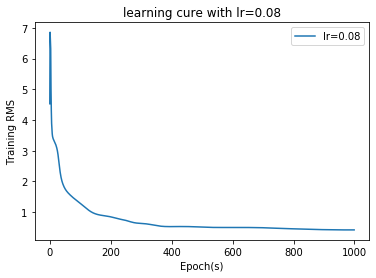

In [12]:
nn = NN([train_X.shape[1], 10, 5,  1],activations=['sigmoid', 'sigmoid', 'linear'], usage = 'regression')
#the network architecture is as the constructer

lr = .08
batch_size = 10
epchos = 1000
#epoch*train_X.shape[0] ~= 10*VC dimension
print(train_X.shape)
learning_curve = nn.train(train_X, train_y, batch_size=batch_size, epochs=epchos, lr = lr)
#lr = 0.5 => too large, 0.1 => ok, 0.01 =>  smooth and as good as 0.1

train_RMS = nn.calc_error(train_X, train_y)
test_RMS = nn.calc_error(test_X, test_y)

plt.title("learning cure with lr={}".format(lr))
plt.xlabel("Epoch(s)")
plt.ylabel("Training RMS")
plt.plot(np.arange(len(learning_curve)), learning_curve, label='lr={}'.format(lr))
plt.legend(loc=0)
print('train_RMS = ', train_RMS, '\n', 'test_RMS = ', test_RMS)

#improve weight initialization by Xavier/HE Init 
#i.e. self.weights.append(np.random.randn(layers[i+1], layers[i])*np.sqrt(layers[i])/2.)
#train_RMS =  24.520031677634964 (0 grad(<0.001) verified by assert(assert(np.linalg.norm(dw[i]) > eps)) )
len(learning_curve)

In [20]:
#experiments on learning rate
lrs = [0.01, 0.05, 0.08, 0.1, 0.15, 0.5]
exp_times = 10
batch_size = 10
epochs = 200

n = len(lrs)
avg_lc = [[0.]*epochs]*n
avg_train_RMS = [0.]*n
avg_test_RMS = [0.]*n


for T in range(exp_times):
    print("exp #", T, end=' ')
    train_X, train_y, test_X, test_y = partition(X, y, ratio=0.75)
    for i in range(n):
        #test lr with model [in , 10, 5, 1], sig, sig, linear
        #lr = 0.5 => too large, 0.1 => ok, 0.01 =>  smooth and as good as 0.1
        nn = NN([train_X.shape[1], 10, 5,  1],activations=['sigmoid', 'sigmoid', 'linear'], usage = 'regression')
        learning_curve = nn.train(train_X, train_y, batch_size=10, epochs=epochs, lr = lrs[i])
        train_RMS = nn.calc_error(train_X, train_y)
        test_RMS = nn.calc_error(test_X, test_y)
        
        avg_lc[i] = [avg_lc[i][k] + learning_curve[k] for k in range(len(avg_lc[i]))]
        avg_train_RMS[i] += train_RMS
        avg_test_RMS[i] += test_RMS


exp # 0 exp # 1 exp # 2 exp # 3 exp # 4 exp # 5 exp # 6 exp # 7 exp # 8 exp # 9 

In [29]:
#avg_lc = [[y*exp_times for y in x] for x in avg_lc]      
#avg_train_RMS = [x*exp_times for x in avg_train_RMS]|
#avg_test_RMS = [x*exp_times for x in avg_test_RMS]
#for reverting excution result cause value to decay

lr = 0.01
 train_RMS =  1.381877604779393  test_RMS =  1.519510049561133
lr = 0.05
 train_RMS =  1.3833931214752926  test_RMS =  1.6506491425169938
lr = 0.08
 train_RMS =  1.189949610556438  test_RMS =  1.550752142984839
lr = 0.1
 train_RMS =  1.2128258210729197  test_RMS =  1.503418898218476
lr = 0.15
 train_RMS =  1.454553046952772  test_RMS =  1.7669272807583234
lr = 0.5
 train_RMS =  10.627442920479515  test_RMS =  10.56892930004896


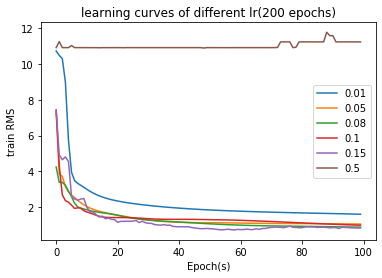

In [28]:
avg_lc = [[y/exp_times for y in x] for x in avg_lc]      
avg_train_RMS = [x/exp_times for x in avg_train_RMS]
avg_test_RMS = [x/exp_times for x in avg_test_RMS]

plt.title("learning curves of different lr(200 epochs)")
plt.xlabel("Epoch(s)")
plt.ylabel("train RMS")

for i in range(n):        
    plt.plot(np.arange(len(avg_lc[i])), avg_lc[i], label='{}'.format(lrs[i]))
    print('lr = '+ str(lrs[i]) +'\n train_RMS = ', avg_train_RMS[i], ' test_RMS = ', avg_test_RMS[i])

plt.legend() 


In [23]:
#experiments on learning rate
lrs = [0.01, 0.05, 0.08, 0.1, 0.15, 0.5]
exp_times = 5
batch_size = 10
epochs =100

n = len(lrs)
avg_lc = [[0.]*epochs]*n
avg_train_RMS = [0.]*n
avg_test_RMS = [0.]*n


for T in range(exp_times):
    print("exp #", T, end=' ')
    train_X, train_y, test_X, test_y = partition(X, y, ratio=0.75)
    for i in range(n):
        #test lr with model [in , 10, 5, 1], sig, sig, linear
        #lr = 0.5 => too large, 0.1 => ok, 0.01 =>  smooth and as good as 0.1
        nn = NN([train_X.shape[1], 10, 5,  1],activations=['sigmoid', 'sigmoid', 'linear'], usage = 'regression')
        learning_curve = nn.train(train_X, train_y, batch_size=10, epochs=epochs, lr = lrs[i])
        train_RMS = nn.calc_error(train_X, train_y)
        test_RMS = nn.calc_error(test_X, test_y)
        
        avg_lc[i] = [avg_lc[i][k] + learning_curve[k] for k in range(len(avg_lc[i]))]
        avg_train_RMS[i] += train_RMS
        avg_test_RMS[i] += test_RMS


exp # 0 exp # 1 exp # 2 exp # 3 exp # 4 

lr = 0.01
 train_RMS =  1.3818776047793928  test_RMS =  1.5195100495611331
lr = 0.05
 train_RMS =  1.3833931214752926  test_RMS =  1.6506491425169938
lr = 0.08
 train_RMS =  1.189949610556438  test_RMS =  1.550752142984839
lr = 0.1
 train_RMS =  1.2128258210729197  test_RMS =  1.503418898218476
lr = 0.15
 train_RMS =  1.454553046952772  test_RMS =  1.766927280758323
lr = 0.5
 train_RMS =  10.627442920479515  test_RMS =  10.568929300048962


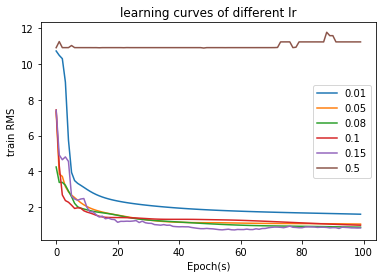

In [24]:
avg_lc = [[y/exp_times for y in x] for x in avg_lc]      
avg_train_RMS = [x/exp_times for x in avg_train_RMS]
avg_test_RMS = [x/exp_times for x in avg_test_RMS]

plt.title("learning curves of different lr(100 epochs)")
plt.xlabel("Epoch(s)")
plt.ylabel("train RMS")

for i in range(n):        
    plt.plot(np.arange(len(avg_lc[i])), avg_lc[i], label='{}'.format(lrs[i]))
    print('lr = '+ str(lrs[i]) +'\n train_RMS = ', avg_train_RMS[i], ' test_RMS = ', avg_test_RMS[i])

plt.legend() 

In [24]:
def save_res(name):
    pathcsv = "./predictions/"
    reg_train_csv = pathcsv + "reg_train_pred_"+name+".csv" 
    reg_test_csv = pathcsv + "reg_test_pred_"+name+".csv" 
    with open(reg_train_csv, 'w', newline='') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(['prediction', 'label'])
        for i in range(train_X.shape[0]):
            writer.writerow([nn.prediction(np.asarray([train_X[i]]))[0][0], train_y[i][0]])
    with open(reg_test_csv, 'w', newline='') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(['prediction', 'label'])
        for i in range(test_X.shape[0]):
            writer.writerow([nn.prediction(np.asarray([test_X[i]]))[0][0], test_y[i][0]])
            
    pathnn = "./savedmodels/"
    savefilename = pathnn +"reg_nn_"+name
    with open(savefilename, 'wb') as fo:
        pickle.dump(nn, fo)

save_res("1107-1")